**ECON 470 Hwk2-2**

**Author:** Ilse Novis 

**Date:** 2/19/2025  

[GitHub Repository](https://github.com/ilsenovis18/ECON470HW2)

\newpage

In [2]:
%matplotlib inline

In [3]:
# Import libraries
import pandas as pd
import numpy as np
import os
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
from scipy.spatial.distance import mahalanobis
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import statsmodels.api as sm
import matplotlib.ticker as ticker
import matplotlib
import seaborn as sns
from statsmodels.formula.api import ols
from sklearn.neighbors import NearestNeighbors
from IPython.display import Markdown, display
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.DtypeWarning)

In [4]:
# Load and inspect cleaned HCRIS dataset
hcris_data = '/Users/ilsenovis/Documents/GitHub/ECON470HW2/data/output/HCRIS_Data.csv'
data = pd.read_csv(hcris_data)

# Convert the 'fy_start' and 'fy_end' columns to datetime format
data['fy_start'] = pd.to_datetime(data['fy_start'])
data['fy_end'] = pd.to_datetime(data['fy_end'])

# Extract the year from the 'fy_start' column
data['fy_year'] = data['fy_start'].dt.year


***Question 1:***  
         How many hospitals filed more than one report in the same year? Show your answer as a line graph of the number of hospitals over time.

In [5]:
# Count distinct providers
num_providers = data['provider_number'].nunique()
print(f"Number of distinct providers: {num_providers}")

Number of distinct providers: 6731


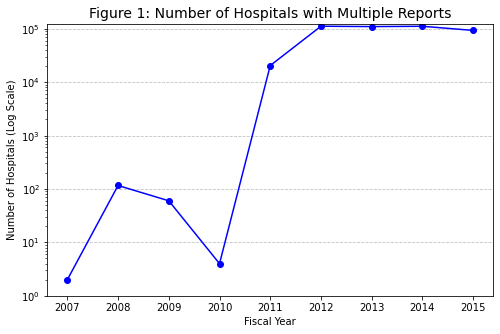

In [6]:
# Count duplicate reports per provider per year
dup_count = data.groupby(['provider_number', 'fy_year']).size().reset_index(name='total_reports')

# Count duplicate reports per year
dup_count = dup_count[dup_count['total_reports'] > 1]

# Summarize duplicates per year
dup_summary = dup_count.groupby(['fy_year'])['total_reports'].sum().reset_index()

# Line plot for hospitals with multiple reports
plt.figure(figsize=(8, 5))
plt.plot(dup_summary['fy_year'].values, dup_summary['total_reports'].values, marker='o', linestyle='-', color='blue')

# Set y-axis to log scale to handle large jumps
plt.yscale('log')
# Ensure x-axis includes all years
plt.xticks(range(2007, 2016))
plt.title('Figure 1: Number of Hospitals with Multiple Reports', fontsize=14)
plt.xlabel('Fiscal Year')
plt.ylabel('Number of Hospitals (Log Scale)')
plt.ylim(1, dup_summary['total_reports'].max() * 1.1)
plt.grid(axis='y', color='gray', linestyle='--', alpha=0.5)
plt.show()

\newpage

***Question 2:***  
        After removing/combining multiple reports, how many unique hospital IDs (Medicare provider numbers) exist in the data?

   fy_year  hosp_count
0     2007        1116
1     2008        6116
2     2009        6041
3     2010        2656
4     2011       20459
5     2012      111296
6     2013      109552
7     2014      110966
8     2015       92751


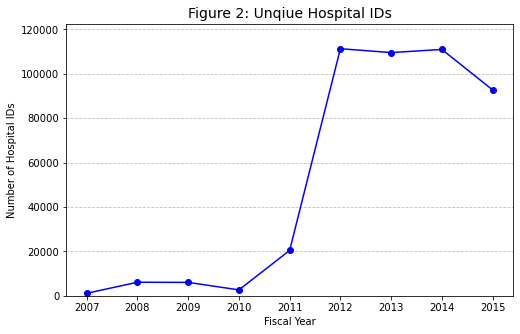

In [7]:
dup_summary = dup_count.groupby('fy_year')['total_reports'].sum().reset_index()
hosp_count = data.groupby('fy_year').size().reset_index(name='hosp_count')
print(hosp_count)

# Count of unique hospitals per year
plt.figure(figsize=(8, 5))
plt.plot(hosp_count['fy_year'].values, hosp_count['hosp_count'].values,
         marker='o', linestyle='-', color='blue')
plt.title('Figure 2: Unqiue Hospital IDs', fontsize=14)
plt.xlabel('Fiscal Year')
plt.ylabel('Number of Hospital IDs')
plt.ylim(0, hosp_count['hosp_count'].max() * 1.1)
plt.grid(axis='y', color='gray', linestyle='--', alpha=0.5)
plt.show()

\newpage

***Question 3:***  
       What is the distribution of total charges (tot_charges in the data) in each year? Show your results with a “violin” plot, with charges on the y-axis and years on the x-axis.

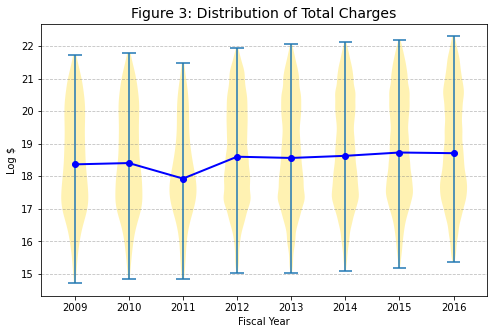

In [8]:
charge_data = data.copy()

# Drop rows where 'tot_charges' is NaN 
charge_data = charge_data.dropna(subset=['tot_charges'])

# Comput 1st and 99th percentiles
charge_data['tot_charges_low'] = charge_data.groupby('year')['tot_charges'].transform(lambda x: np.nanpercentile(x, 1))
charge_data['tot_charges_high'] = charge_data.groupby('year')['tot_charges'].transform(lambda x: np.nanpercentile(x, 99))

# Filter out extreme vlaues and missing data
charge_data = charge_data[
    (charge_data['tot_charges'] > charge_data['tot_charges_low']) &
    (charge_data['tot_charges'] < charge_data['tot_charges_high']) &
     charge_data['tot_charges'].notna() &
     (charge_data['year'] > 2008)
]

# Compute log of total charges
charge_data['log_charge'] = np.log(charge_data['tot_charges'])

# Prepare data for violin plot
years = sorted(charge_data['year'].unique())
charge_violin_data = [charge_data[charge_data['year'] == y]['log_charge'].dropna().values for y in years]

# Plot distribution of total charges
fig, ax = plt.subplots(figsize=(8, 5))
parts = ax.violinplot(charge_violin_data, positions=years, showmedians=False)

# Customize Violin Plot
for pc in parts['bodies']:
    pc.set_facecolor('gold')
    pc.set_alpha(0.3)

# Add median line
median = charge_data.groupby('year')['log_charge'].median()
plt.plot(years, median.values, marker='o', linestyle='-', color='blue', linewidth=2)

# Format plot
plt.title('Figure 3: Distribution of Total Charges', fontsize=14)
plt.xlabel('Fiscal Year')
plt.ylabel('Log $')
plt.grid(axis='y', color='gray', linestyle='--', alpha=0.5)
plt.show()


\newpage

***Question 4:***  
        What is the distribution of estimated prices in each year? 

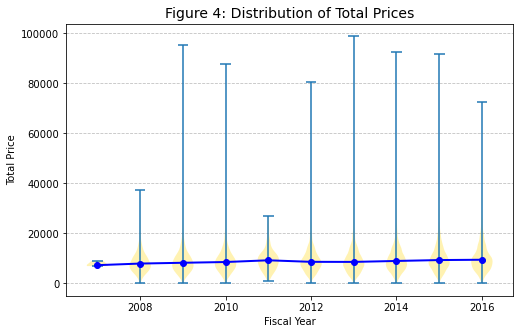

In [9]:
if not isinstance(data, pd.DataFrame):
    data = pd.read_csv(hcris_data)

# Price Calculation
data['discount_factor'] = 1 - data['tot_discounts'] / data['tot_charges']
data['price_num'] = (
    (data['ip_charges'] + data['icu_charges'] + data['ancillary_charges']) * 
    data['discount_factor']
) - data['tot_mcare_payment']
data['price_denom'] = data['tot_discharges'] - data['mcare_discharges']
data['price'] = data['price_num'] / data['price_denom']

# Replace invalid denominators (zero or NaN) with NaN
data['price_denom'] = np.where(data['price_denom'] > 0, data['price_denom'], np.nan)

# Compute price only for valid values
data['price'] = data['price_num'] / data['price_denom']

# Filtering the data
price_data = data[
    (data['price_denom'] > 100) &
    (~data['price_denom'].isna()) &
    (data['price_num'] > 0) &
    (~data['price_num'].isna()) &
    (data['price'] < 100000) &
    (data['beds'] > 30) &
    (~data['beds'].isna())
]

# Prepare for Violin plot
years = sorted(price_data['year'].unique())
price_violin_data = [price_data[price_data['year'] == y]['price'].dropna().values for y in years]

# Plot distribution of total charges
fig, ax = plt.subplots(figsize=(8, 5))
parts = ax.violinplot(price_violin_data, positions=years, showmedians=False)

# Customize violin plot
for pc in parts['bodies']:
    pc.set_facecolor('gold')
    pc.set_alpha(0.3)

# Add median line
median = price_data.groupby('year')['price'].median()
plt.plot(years, median.values, marker='o', linestyle='-', color='blue', linewidth=2)

# Format plot
plt.title('Figure 4: Distribution of Total Prices', fontsize=14)
plt.xlabel('Fiscal Year')
plt.ylabel('Total Price')
plt.grid(axis='y', color='gray', linestyle='--', alpha=0.5)
plt.show()

\newpage

***Question 5:***  
        Calculate the average price among penalized versus non-penalized hospitals. 

In [10]:
# Ensure 'penalty' is created as a float column using. loc
price_data = data.copy()
price_data.loc[:, 'penalty'] = ((price_data['hvbp_payment'].fillna(0) - price_data['hrrp_payment'].fillna(0)).abs().astype(float) < 9)

# Filter data for the year 2012
pen_data_2012 = price_data[price_data['year'] == 2012].copy()

# Compute Quartiles
beds_q1 = pen_data_2012['beds'].quantile(0.25)
beds_q2 = pen_data_2012['beds'].quantile(0.50)
beds_q3 = pen_data_2012['beds'].quantile(0.75)
beds_q4 = pen_data_2012['beds'].max()

# Assign bed quartiles
pen_data_2012['bed_quart'] = np.select(
    [
        pen_data_2012['beds'] < beds_q1,
        (pen_data_2012['beds'] >= beds_q1) & (pen_data_2012['beds'] < beds_q2),
        (pen_data_2012['beds'] >= beds_q2) & (pen_data_2012['beds'] < beds_q3),
        pen_data_2012['beds'] >= beds_q3
    ],
    [1, 2, 3, 4],
    default=0
)

# Filter out invalid quartile values
pen_data_2012 = pen_data_2012[pen_data_2012['bed_quart'] > 0]

# Compute average price by penalty status
avg_pen = pen_data_2012.groupby('penalty')['price'].mean().round(2)
avg_pen

penalty
False    10200.32
True      9748.02
Name: price, dtype: float64

\newpage

***Question 6:***  
        Split hospitals into quartiles based on bed size. Provide a table of the average price among treated/control groups for each quartile. 

In [10]:
# Compute the average price by treatment status (penalized vs. non-penalized) and quartile
quartile_avg_price = pen_data_2012.groupby(['bed_quart', 'penalty'])['price'].mean().unstack()

# Rename columns for clarity
quartile_avg_price.columns = ['Control (No Penalty)', 'Treated (Penalty)']
quartile_avg_price.index.name = 'Bed Quartile'
quartile_avg_price = quartile_avg_price.round(2)

# Display the final table
print("\nTable: Average Price by Treatment Status for Each Bed Size Quartile\n")
quartile_avg_price


Table: Average Price by Treatment Status for Each Bed Size Quartile



,Control (No Penalty),Treated (Penalty)
Bed Quartile,,
1,15254.11,26868.59
2,9263.94,9223.96
3,9019.22,8423.95
4,11414.75,10904.63


\newpage

***Question 7:***  
        Use different estimators to calculate ATE. 

Q7.A: Nearest Neighbor Matching (Inverse Variance)

In [11]:
# Prepare data
match_data = pen_data_2012.copy()
match_data = match_data.dropna()

# Separate treated and control groups
treated = match_data[match_data['penalty'] == True]
control = match_data[match_data['penalty'] == False]

# Use bed quartiles as the matching variables
X_treated = treated[['bed_quart']].values
X_control = control[['bed_quart']].values

# Use inverse variance weighting for distance
bed_var = match_data.groupby('bed_quart')['price'].var().fillna(1)
inv_var_weights = 1 / bed_var.loc[treated['bed_quart']].values

# Perform NN Matching (1-to-1)
nn = NearestNeighbors(n_neighbors=1, metric='euclidean')
nn.fit(X_control)
_, indices = nn.kneighbors(X_treated)

# Get matched control prices
matched_control_prices = control.iloc[indices.flatten()]['price'].values
treated_prices = treated['price'].values

# Compute ATE
ATE_nn = np.mean(treated_prices - matched_control_prices)
print(f"Nearest Neighbor Matching ATE: {ATE_nn:.2f}")

Nearest Neighbor Matching ATE: 28791.02


\newpage

##### Q7.B: Nearest Neighbor Matching using Mahalanobis Distance

In [12]:
# Prepare data
match_mah_data = pen_data_2012.copy()
match_mah_data = match_mah_data.dropna()

# Separate treated and control groups
treated_mah = match_mah_data[match_mah_data['penalty'] == True]
control_mah = match_mah_data[match_mah_data['penalty'] == False]

# Use bed quartiles as matching variables
X_mah_treated = treated[['bed_quart']].values
X_mah_control = control[['bed_quart']].values

# Compute inverse covariance matrix for Mahalonobis distance
cov_matrix = np.cov(match_mah_data[['bed_quart']].values.T, rowvar=False)
cov_matrix = np.atleast_2d(cov_matrix)
inv_cov_matrix = np.linalg.inv(cov_matrix)

# Compute Mahalanobis distance between each treated and control unit
dist_matrix = np.array([
    [mahalanobis(t, c, inv_cov_matrix) for c in X_mah_control]
    for t in X_mah_treated
])

# Perform NN Matching (1-to-1)
nn_indices = dist_matrix.argmin(axis=1)

# Get matched control prices
matched_mah_control_prices = control_mah.iloc[nn_indices]['price'].values
treated_mah_prices = treated_mah['price'].values

# Compute ATE
ATE_nn_mah = np.mean(treated_mah_prices - matched_mah_control_prices)
print(f"Nearest Neighbor Matching (Mahalanobis) ATE: {ATE_nn_mah:.2f}")

Nearest Neighbor Matching (Mahalanobis) ATE: 24298.26


\newpage

##### Q7.C: Propesntiy Score Matching and Weighting

In [13]:
# Prepare data
ps_model_data = pen_data_2012.copy()
ps_model_data = ps_model_data.dropna()

# Fit log regression model to estimate PS 
logit_model = LogisticRegression()
logit_model.fit(ps_model_data[['beds', 'mcaid_discharges', 'ip_charges', 'mcare_discharges', 'tot_mcare_payment']], ps_model_data['penalty'])

# Compute PS scores (predicted possibilities)
ps_model_data['ps'] = logit_model.predict_proba(ps_model_data[['beds', 'mcaid_discharges', 'ip_charges', 'mcare_discharges', 'tot_mcare_payment']])[:, 1]

# Compute inverse probability weights (IPW)
ps_model_data['ipw'] = np.where(
    ps_model_data['penalty'] == 1,
    1 / ps_model_data['ps'], #For treated
    1 / (1- ps_model_data['ps']) #For control
)

# Compute weighte means for treated and control groups
mean_treated =  np.average(ps_model_data.loc[ps_model_data['penalty'] == 1, 'price'],
                           weights=ps_model_data.loc[ps_model_data['penalty'] ==1, 'ipw'])

mean_control = np.average(ps_model_data.loc[ps_model_data['penalty'] == 0, 'price'],
                          weights=ps_model_data.loc[ps_model_data['penalty'] == 0, 'ipw'])

# Compute ATE
ATE_ipw = mean_treated - mean_control

# Print results
print(f"Mean Price (Treated): {mean_treated:.2f}")
print(f"Mean Price (Control): {mean_control:.2f}")
print(f"ATE (IPW): {ATE_ipw:.2f}")

Mean Price (Treated): 23033.46
Mean Price (Control): 9989.76
ATE (IPW): 13043.69


\newpage

##### Q7.D: Simple Regression for ATE Estimation

In [14]:
# Ensure relevant columns are numeric
numeric_cols = ['price', 'penalty', 'beds', 'mcaid_discharges', 
                'ip_charges', 'mcare_discharges', 'tot_mcare_payment']

# Ensure all required columns exist in pen_data_2012
missing_cols = [col for col in numeric_cols if col not in pen_data_2012.columns]
if missing_cols:
    print(f"Missing columns: {missing_cols}")
    raise ValueError("Some required columns are missing from pen_data_2012")

# Drop rows with NaN values in required columns
reg_data = pen_data_2012.dropna(subset=numeric_cols).copy()

# Convert relevant columns to numeric (force conversion)
reg_data[numeric_cols] = reg_data[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Drop any remaining NaN values after conversion
reg_data = reg_data.dropna()

# Check data types
print(reg_data.dtypes)

# Check if any remaining non-numeric values exist
if reg_data.isnull().sum().sum() > 0:
    print("There are still NaN values in reg_data after conversion!")
    reg_data = reg_data.dropna()

# Create interaction terms
reg_data['beds_diff'] = reg_data['penalty'] * (reg_data['beds'] - reg_data['beds'].mean())
reg_data['mcaid_diff'] = reg_data['penalty'] * (reg_data['mcaid_discharges'] - reg_data['mcaid_discharges'].mean())
reg_data['ip_diff'] = reg_data['penalty'] * (reg_data['ip_charges'] - reg_data['ip_charges'].mean())
reg_data['mcare_diff'] = reg_data['penalty'] * (reg_data['mcare_discharges'] - reg_data['mcare_discharges'].mean())
reg_data['mpay_diff'] = reg_data['penalty'] * (reg_data['tot_mcare_payment'] - reg_data['tot_mcare_payment'].mean())

# Define dependent and independent variables
X = reg_data[['penalty', 'beds', 'mcaid_discharges', 'ip_charges', 'mcare_discharges', 
              'tot_mcare_payment', 'beds_diff', 'mcaid_diff', 'ip_diff', 'mcare_diff', 'mpay_diff']]

# Ensure X is fully numeric
X = X.apply(pd.to_numeric, errors='coerce')

# Drop rows with NaN values in X
X = X.dropna()
y = reg_data.loc[X.index, 'price'].astype(float)  # Ensure y is numeric

# Verify no missing values
assert not X.isnull().values.any(), "X still contains NaN values!"
assert not y.isnull().values.any(), "y still contains NaN values!"

# Add constant term for regression
X = sm.add_constant(X)

# Run regression
reg_model = sm.OLS(y, X).fit()

# Display results
print(reg_model.summary())

# Extract ATE estimate (coefficient of 'penalty')
ate_regression = reg_model.params['penalty']
print(f"Estimated ATE using One-Step Regression: {ate_regression:.2f}")

provider_number                     int64
fy_start                   datetime64[ns]
fy_end                     datetime64[ns]
date_processed                     object
date_created                       object
beds                              float64
tot_charges                       float64
tot_discounts                     float64
tot_operating_exp                 float64
ip_charges                        float64
icu_charges                       float64
ancillary_charges                 float64
tot_discharges                    float64
mcare_discharges                  float64
mcaid_discharges                  float64
tot_mcare_payment                 float64
secondary_mcare_payment           float64
street                             object
city                               object
state                              object
zip                                object
county                             object
hvbp_payment                      float64
hrrp_payment                      

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

\newpage

***Question 7:***  Final Summary Table 

In [15]:
ate_results = {
    "Estimator": ["Nearest Neighbor Matching",
                  "Mahalanobis Distance Matching",
                  "Inverse Propensity Weighting"],
    "ATE Estimator": [ATE_nn, ATE_nn_mah, ATE_ipw]
}

# Convert to DF
ate_table = pd.DataFrame(ate_results)

ate_table

,Estimator,ATE Estimator
0,Nearest Neighbor Matching,28791.021695
1,Mahalanobis Distance Matching,24298.260886
2,Inverse Propensity Weighting,13043.694639


\newpage

***Question 8:***  
        With these different treatment effect estimators, are the results similar, identical, very different?

---------------------------------------------------------------------------------------------------------------------
The results from the different treatment effect estimators vary significantly. Nearest Neighbor Matching produced the highest estimate at ***28,791***, while Mahalanobis Distance Matching yielded a slightly lower estimate of ***24,298***. Inverse Propensity Weighting, however, resulted in a much lower estimate of ***13,043***.

These differences arise because each estimator makes different assumptions and applies different methodologies:
	
- ***Nearest Neighbor Matching***: pairs treated and control units based on ***similarity*** in key covariates, which can reduce bias but is sensitive to how matches are selected.
- ***Mahalanobis Distance Matching***: accounts for ***correlations*** between covariates, potentially making it more robust, which could explain why its estimate is lower than simple nearest neighbor matching.
- ***Inverse Propensity Weighting (IPW)***: adjusts for differences in the ***probability*** of treatment, effectively reweighting observations to approximate a randomized experiment. The lower estimate suggests that after adjusting for observed covariates, the estimated treatment effect is smaller.

The fact that IPW produced a much lower estimate indicates that selection into treatment might be influenced by observable factors, and adjusting for those reduces the estimated effect.

\newpage

***Question 9:***  
        Do you think you’ve estimated a causal effect of the penalty? Why or why not? (just a couple of sentences)

---------------------------------------------------------------------------------------------------------------------
While techniques like propensity score weighting and matching help reduce selection bias, they only account for observed confounders. If there are unobserved factors influencing both the penalty and hospital prices (e.g., hospital quality, patient mix), the estimates may still be biased. Without a truly randomized experiment or strong instrumental variable, we cannot definitively claim a causal relationship.

\newpage

***Question 10:***  
        Briefly describe your experience working with these data (just a few sentences). Tell me one thing you learned and one thing that really aggravated or surprised you.

---------------------------------------------------------------------------------------------------------------------
One thing that really aggravated me was that the datasets didn't download correctly so it took a while to actually clean/fix the data before I could merge it into the final dataset. One thing that suprised me was the large difference in the charges from the hospitals versus the actual prices